saved as: ecg_waveforms.csv


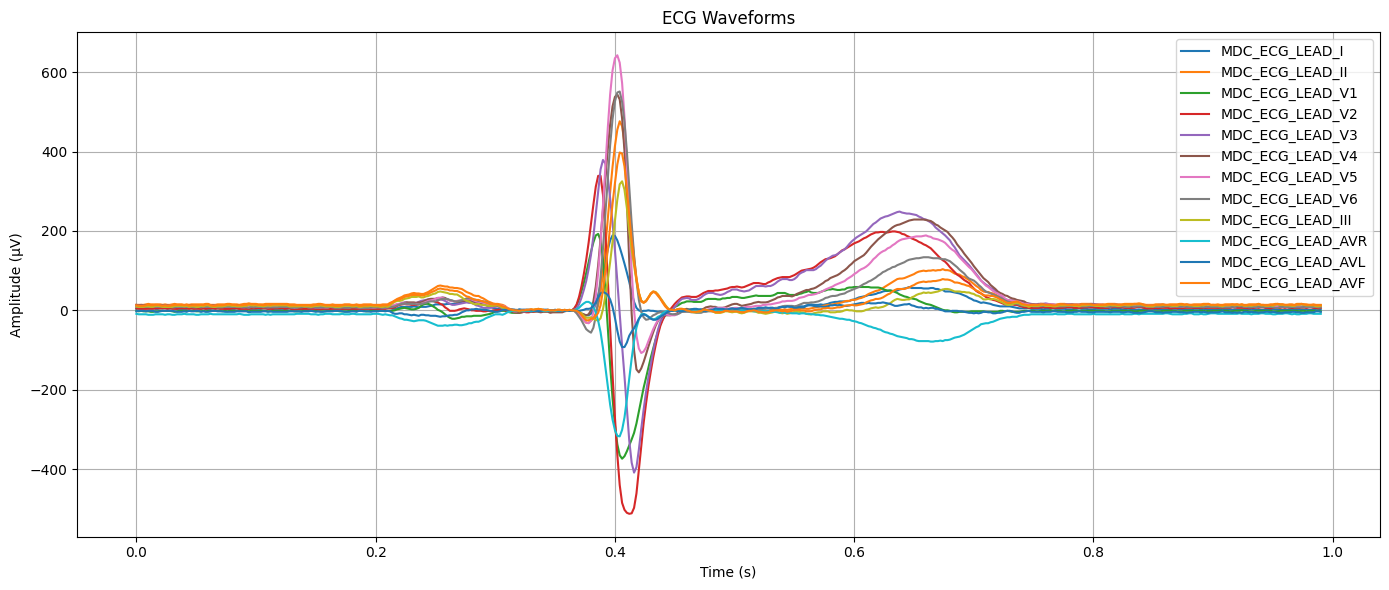

In [9]:
import xml.etree.ElementTree as ET
import csv
import matplotlib.pyplot as plt
import os

def parse_ecg_xml(xml_file, output_csv):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    ns = {'hl7': 'urn:hl7-org:v3'}

    leads = {}
    sampling_rate = 500 
    max_length = 0

    for sequence in root.findall(".//hl7:sequence", ns):
        code_tag = sequence.find("hl7:code", ns)
        value_tag = sequence.find("hl7:value", ns)

        if code_tag is None or value_tag is None:
            continue

        code = code_tag.attrib.get("code", "").strip()

        if code == "TIME_ABSOLUTE":
            increment_tag = value_tag.find("hl7:increment", ns)
            if increment_tag is not None:
                increment_value = float(increment_tag.attrib.get("value", "0.002"))
                sampling_rate = 1.0 / increment_value
            continue

        # Extract waveform data
        digits_tag = value_tag.find("hl7:digits", ns)
        scale_tag = value_tag.find("hl7:scale", ns)

        if digits_tag is not None and scale_tag is not None:
            scale = float(scale_tag.attrib.get("value", "1.0"))
            digits = [int(d) * scale for d in digits_tag.text.strip().split()]
            leads[code] = digits
            max_length = max(max_length, len(digits))

    rows = []
    for i in range(max_length):
        row = {'time': round(i / sampling_rate, 6)}
        for lead in leads:
            row[lead] = leads[lead][i] if i < len(leads[lead]) else ''
        rows.append(row)

    fieldnames = ['time'] + list(leads.keys())
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

    print(f"saved as: {output_csv}")
    return leads, sampling_rate

def plot_leads(leads, sampling_rate):
    time = lambda n: [i / sampling_rate for i in range(len(n))]

    plt.figure(figsize=(14, 6))
    for lead, values in leads.items():
        plt.plot(time(values), values, label=lead)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (μV)")
    plt.title("ECG Waveforms")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

xml_input = "aEcg.xml"
csv_output = "ecg_waveforms.csv"

leads_data, fs = parse_ecg_xml(xml_input, csv_output)
plot_leads(leads_data, fs)
